In [28]:
import os

os.makedirs("scripts", exist_ok=True)
os.makedirs("models", exist_ok=True)
os.makedirs("data/splits/tightcrop", exist_ok=True)
os.makedirs("results", exist_ok=True)


In [ ]:
%%writefile scripts/data.py
# scripts/data.py
#
# This file defines a PyTorch Dataset that reads image paths and labels from a CSV.
# Those CSV files are expected to be generated by dataset_prep.py and look like:
#   data/splits/tightcrop/{train,val,test}.csv
#
# Each CSV row should have:
#   - image_path  -> where the MRI image lives on disk
#   - class       -> one of: glioma / meningioma / pituitary / notumor

import os                     # I use this to test whether a path exists on disk
from pathlib import Path      # nicer path joining across different OSes (Windows/Linux/Mac)

import pandas as pd           # CSV reading and row access
from PIL import Image         # image loading (PIL is standard for torchvision)

import torch                  # tensors and random generators
from torch.utils.data import Dataset  # base class for PyTorch datasets
import torchvision.transforms as T    # common image transforms and augmentation


class AddGaussianNoise:
    
    """
    Custom transform: sometimes add small Gaussian noise to a tensor image.
    I apply it only during training (see build_transforms), to improve robustness.
    """
    def __init__(self, std=0.02, p=0.5):
        self.std = std  # how strong the noise is
        self.p = p      # probability of applying noise on a given sample

    def __call__(self, x):
        # x is expected to be a torch tensor in [0,1] already (after ToTensor()).

        # Drew a random number in [0,1). If it's greater than p, skip noise.
        # Note: this logic means "apply noise with probability p".
        if torch.rand(1).item() > self.p:
            return x

        # Created noise with same shape as x: N(0, std^2).
        noise = torch.randn_like(x) * self.std

        # Added the noise to the image tensor.
        x = x + noise

        # Clamped back to valid pixel range [0,1] so we don't create weird values.
        return torch.clamp(x, 0.0, 1.0)


def _resolve_path(p, project_root):
    
    """
    Tried to make CSV image paths portable.

    Sometimes the CSV contains absolute paths from a different machine
    (for instance., my Mac). On Kaggle those paths won't exist.

    This function tries a few reasonable conversions:
      1) If the path exists as-is, use it.
      2) If it contains /data/processed/, rebuild under project_root.
      3) Otherwise try treating it as relative to project_root.
      4) If all fail, return original and let __getitem__ fail (it's for my debugging).
    """

    # If the path is already valid on this machine, I'm done.
    if os.path.exists(p):
        return p

    # Converted backslashes to forward slashes so Windows-style paths don’t break parsing.
    p2 = str(p).replace("\\", "/")

    # This is a marker folder that might appear in old absolute paths.
    key = "/data/processed/"

    # Finding where that marker occurs in the path.
    idx = p2.find(key)

    # If I found the marker, I tried rebuilding a path relative to project_root.
    if idx != -1:
        # idx+1 removes a leading '/' so that Path(project_root) / rel joins properly
        rel = p2[idx + 1:]
        cand = str(Path(project_root) / rel)

        # If that candidate exists, used it.
        if os.path.exists(cand):
            return cand

    # Fallback, tried treating the whole p2 as a path relative to project_root.
    cand2 = str(Path(project_root) / p2)
    if os.path.exists(cand2):
        return cand2

    # Final fallback: return original path.

    # This will likely fail in Image.open(), but that can be good for debugging.
    return p


def build_transforms(train, mean, std):
    
    """
    Built a torchvision transform pipeline.
    - If train=True: add random augmentations.
    - Always: ToTensor and Normalize.

    mean/std should be sequences of 3 values (for RGB channels),
    for instance. mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225).
    """
    ops = []  # I collected operations in a list, then compose them

    if train:
        # Light augmentations to help generalization (don’t overfit exact poses).
        ops.extend([
            T.RandomRotation(degrees=15),                 # rotate image randomly within +/- 15 degrees
            T.RandomHorizontalFlip(p=0.5),                # flip half the time
            T.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # shift image slightly (up to 5% of width/height)
        ])

    # Converted PIL image to float torch tensor:
    # shape becomes [C,H,W] and values become [0,1].
    ops.extend([T.ToTensor()])

    if train:
        # Added small noise sometimes, only for training.
        ops.append(AddGaussianNoise(std=0.02, p=0.5))

    # Normalize channels: (x - mean) / std
    # This helps training stability and matches expected input stats for many backbones.
    ops.append(T.Normalize(mean=mean, std=std))

    # Composed into a single callable transform.
    return T.Compose(ops)


class BrainMRICSV(Dataset):
    
    """
    A PyTorch Dataset that reads MRI image paths and labels from a CSV file.

    Returns:
      x       : transformed image tensor [3,H,W]
      y       : integer class id
      img_path: resolved image path (useful for debugging / visualization)
    """
    def __init__(self, csv_path, class_names, transform, project_root):
        
        # Loaded the CSV into a dataframe so we can index rows easily.
        self.df = pd.read_csv(csv_path)

        # Kept class names in a stable order (this defines label -> index mapping).
        self.class_names = class_names

        # Created mapping like {"glioma":0, "meningioma":1, ...}
        self.class_to_idx = {c: i for i, c in enumerate(class_names)}

        # Stored transform pipeline (train/val/test versions).
        self.transform = transform

        # Used by _resolve_path() to rebuild paths in a portable way.
        self.project_root = project_root

    def __len__(self):
        
        # Dataset length = number of rows in CSV.
        return len(self.df)

    def __getitem__(self, idx):
        # Grabbed the row at position idx.
        row = self.df.iloc[idx]

        # Resolved the image path to something valid on this machine.
        img_path = _resolve_path(row["image_path"], self.project_root)

        # Read class label as a string, e.g. "glioma".
        y_str = row["class"]

        # Converted string label -> integer index.
        y = self.class_to_idx[y_str]

        # Loaded the image from disk and force RGB (3 channels).
        img = Image.open(img_path).convert("RGB")

        # Applied transforms: augment (if training), tensor conversion, normalization, etc.
        x = self.transform(img)

        # Returned tensor, label index, and path (path helps debugging and explainability later).
        return x, y, img_path

Overwriting scripts/data.py


In [14]:
%%writefile scripts/dataset_prep.py
# dataset_prep.py
# I started working on dataset preparation from 12th november 2025

# -------------------------------------------------------------------
# dataset preparation pipeline (what I already did)
#
# In this script I had:
#   - walked the original Kaggle brain tumour MRI folders and recorded
#     every file path together with its class and Kaggle split
#     (Training / Testing),
#   - computed SHA1 hashes to detect and remove exact byte-for-byte
#     duplicate files, while also saving a detailed duplicate summary,
#   - audited every deduplicated raw image for geometry and intensity:
#       – width, height, aspect ratio,
#       – mean / std / min / max grayscale intensity,
#       – conservative flags for too dark, too bright, low contrast,
#         and a combined "suspect" quality flag,
#   - produced CSV summaries for raw resolutions and quality flags so
#     that I could describe the original dataset objectively in the
#     report,
#   - created a *leakage-safe* split aligned to Kaggle's intended protocol:
#       - Kaggle Training -> stratified Train/Val
#       - Kaggle Testing  -> held-out Test (never used for training)
#   - defined a tight brain-cropping function that removed black
#     background based on an intensity threshold plus a small margin,
#   - applied this crop to every image in the split, resized to
#     224x224 (matching ImageNet / ResNet50V2 / RViT defaults),
#     converted to RGB, and saved them into a clean
#     data/processed/tightcrop/{split}/{class}/ structure,
#   - saved train/val/test CSVs that point to these cropped 224×224
#     images (for model training and evaluation),
#   - saved an overall split summary CSV with per-class counts per
#     split, which I later used to generate figures in dataset_plots.py.
#
# This file therefore gave me a single, reproducible, auditable
# pipeline from raw Kaggle folders -> cleaned, cropped 224x224 dataset
# and analysis artefacts for the project's methodology section.
# -------------------------------------------------------------------

"""
Dataset preparation script for HybridResNet50V2–RViT brain tumour classification.

This file builds one reproducible pipeline that:

  - walks the raw Kaggle folders and records exactly what is there,
  - removes byte-for-byte duplicate files using SHA1 with a leakage-safe policy
    (prefer keeping Kaggle Testing copies when duplicates exist across splits),
  - audits raw images for geometry and intensity problems
    (so we can describe “suspect” images with evidence),
  - creates a Kaggle-aligned evaluation protocol:
      * Kaggle Training -> stratified Train/Val split (default 80/20),
      * Kaggle Testing  -> held-out Test set,
  - and finally writes *cropped* 224×224 RGB images and CSVs for model training.

Important design decisions:

  - All model training uses only the cropped 224×224 images.
  - Cropping is done first (tight crop around brain region), then resized to 224×224.
  - The audit (intensity, duplicates) is always done on the raw
    uncropped images so we can describe the original dataset properly.
  - Exact duplicates are removed BEFORE splitting, and duplicates that cross
    Training/Testing are resolved by keeping the Testing copy to avoid leakage.
"""

import os
from pathlib import Path
import hashlib
import math

import numpy as np
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm


# -------------------------------------------------------------------
# CONFIGURATION SECTION
# -------------------------------------------------------------------

from pathlib import Path

# Kaggle paths
RAW_DATA_DIR = Path("/kaggle/input/btc-dataset")
PROJECT_ROOT = Path("/kaggle/working")

# 🔑 FIX: point to actual dataset root
RAW_ROOT = RAW_DATA_DIR / "kaggle_brain_mri_scan_dataset"

PROCESSED_BASE = PROJECT_ROOT / "data" / "processed"
SPLITS_BASE = PROJECT_ROOT / "data" / "splits"
RESULTS_DIR = PROJECT_ROOT / "results"

VARIANT = "tightcrop"
PROCESSED_ROOT = PROCESSED_BASE / VARIANT
SPLITS_ROOT = SPLITS_BASE / VARIANT

SUMMARY_PATH                 = RESULTS_DIR / "dataset_summary.csv"
RAW_STATS_PATH               = RESULTS_DIR / "raw_image_stats.csv"
RAW_RESOLUTION_SUMMARY_PATH  = RESULTS_DIR / "raw_resolution_summary.csv"
RAW_QUALITY_SUMMARY_PATH     = RESULTS_DIR / "raw_quality_flags_summary.csv"
RAW_CLASS_COUNTS_PATH        = RESULTS_DIR / "raw_class_counts_by_source.csv"
DUPLICATES_PATH              = RESULTS_DIR / "duplicate_files.csv"
DUPLICATE_SUMMARY_PATH       = RESULTS_DIR / "duplicate_summary.csv"


IMG_SIZE = (224, 224)
CLASSES = ["glioma", "meningioma", "pituitary", "notumor"]
RANDOM_STATE = 42

# Kaggle-aligned split:
# - Training -> Train/Val
# - Testing  -> Test (held-out)
VAL_FRACTION_OF_TRAINING = 0.20   # 80/20 split inside Kaggle Training

# Dedup policy:
# If an exact duplicate exists in BOTH Training and Testing, keep Testing copy.
PREFER_TESTING_ON_CROSS_SPLIT_DUPLICATES = True

BACKGROUND_INTENSITY_THRESHOLD = 5
CROP_MARGIN = 10

# Only process real image files (prevents .DS_Store, Thumbs.db, etc.)
ALLOWED_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}


def _get_resample():
    """
    Pillow version compatibility: Image.Resampling exists in newer versions.
    We pick LANCZOS for best downsampling quality.
    """
    try:
        return Image.Resampling.LANCZOS
    except AttributeError:
        return Image.LANCZOS


RESAMPLE = _get_resample()


# -------------------------------------------------------------------
# COLLECTING RAW IMAGE PATHS
# -------------------------------------------------------------------

def collect_images() -> pd.DataFrame:
    """
    Walk through the raw Kaggle folders and build a DataFrame.

    For each file record:
      - orig_path    : full path on disk
      - class        : glioma / meningioma / pituitary / notumor
      - source_split : "training" or "testing" (Kaggle's folder)
    """
    records = []

    for split in ["Training", "Testing"]:
        for cls in CLASSES:
            folder = RAW_ROOT / split / cls
            if not folder.exists():
                continue

            for p in folder.iterdir():
                if not p.is_file():
                    continue

                # Skip hidden/system files and non-image extensions
                if p.name.startswith("."):
                    continue
                if p.suffix.lower() not in ALLOWED_EXTS:
                    continue

                records.append(
                    {
                        "orig_path": str(p),
                        "class": cls,
                        "source_split": split.lower(),  # "training" / "testing"
                    }
                )

    df = pd.DataFrame(records)
    print(f"Total images found (before deduplication): {len(df)}")
    return df


def save_raw_class_counts(df: pd.DataFrame):
    """
    Summarise how many images there are per class in Kaggle's
    original Training vs Testing folders.

    Output: results/raw_class_counts_by_source.csv
    """
    RAW_CLASS_COUNTS_PATH.parent.mkdir(parents=True, exist_ok=True)

    if df.empty:
        print("No images found; raw class counts not saved.")
        return

    counts = (
        df.groupby(["source_split", "class"])
        .size()
        .reset_index(name="count")
        .sort_values(["source_split", "class"])
    )

    counts.to_csv(RAW_CLASS_COUNTS_PATH, index=False)
    print(f"Saved raw class counts (by Kaggle split) to {RAW_CLASS_COUNTS_PATH}")
    print(counts)


# -------------------------------------------------------------------
# EXACT DUPLICATE REMOVAL (SHA1) - LEAKAGE SAFE
# -------------------------------------------------------------------

def sha1_of_file(path: str, block_size: int = 65536) -> str:
    """
    Compute SHA1 hash of a file.
    If two files have the same SHA1, they are byte-for-byte identical.
    """
    h = hashlib.sha1()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(block_size), b""):
            h.update(chunk)
    return h.hexdigest()

def processed_filename_for(orig_path: str) -> str:
    """
    Build a unique, deterministic filename for the processed image
    to avoid collisions (same src.name in different folders).

    We use SHA1(file_bytes) + original extension.
    """
    p = Path(orig_path)
    return f"{sha1_of_file(str(p))}{p.suffix.lower()}"


def drop_duplicates_leakage_safe(df: pd.DataFrame):
    """
    Remove exact duplicate files based on SHA1, using a leakage-safe policy.

    Key rule:
      - If a duplicate group spans BOTH Kaggle Training and Kaggle Testing,
        we KEEP the Testing copy and DROP the Training copy(s).

    Returns:
      - dedup_df : DataFrame of kept rows only (unique SHA1)
      - dups_df  : DataFrame of all rows that belong to duplicate groups,
                  including which file was kept/dropped
    """
    if df.empty:
        return df.copy(), pd.DataFrame()

    print("Computing SHA1 hashes for duplicate detection...")
    df = df.copy()
    df["sha1"] = df["orig_path"].apply(sha1_of_file)

    before = len(df)

    # Identify duplicate groups (size >= 2)
    dup_mask = df.duplicated(subset="sha1", keep=False)
    dups_df = df[dup_mask].copy()

    if dups_df.empty:
        print("No duplicate files detected based on SHA1 hashes.")
        dedup_df = df.reset_index(drop=True)
        print(f"Unique files after deduplication: {len(dedup_df)}")
        return dedup_df, dups_df

    keep_indices = []

    # For deterministic behaviour, we sort paths inside each group
    for sha1, group in dups_df.groupby("sha1"):
        g = group.sort_values(["source_split", "orig_path"]).copy()

        has_testing = (g["source_split"] == "testing").any()
        has_training = (g["source_split"] == "training").any()

        # Leakage-safe decision:
        if PREFER_TESTING_ON_CROSS_SPLIT_DUPLICATES and has_testing and has_training:
            # Keep ONE testing copy (deterministic: lexicographically smallest testing path)
            keep_row = g[g["source_split"] == "testing"].sort_values("orig_path").iloc[0]
        else:
            # Otherwise keep ONE file deterministically (smallest path)
            keep_row = g.sort_values("orig_path").iloc[0]

        keep_indices.append(int(keep_row.name))

    # Keep all non-duplicates + one representative from each duplicate group
    non_dup_df = df[~dup_mask].copy()
    kept_from_dups_df = df.loc[keep_indices].copy()

    dedup_df = pd.concat([non_dup_df, kept_from_dups_df], axis=0).reset_index(drop=True)

    after = len(dedup_df)
    print(f"Unique files after deduplication: {after}")
    print(f"Removed {before - after} duplicate file entries (if any).")

    # Augment dups_df with keep/drop info for auditing
    dups_df = dups_df.copy()
    dups_df["kept"] = False

    # Mark kept rows inside duplicate groups
    kept_set = set(keep_indices)
    dups_df.loc[dups_df.index.isin(kept_set), "kept"] = True

    # Also include which path was kept in the group (helpful for report/audit)
    kept_path_by_sha1 = (
        dups_df[dups_df["kept"]]
        .set_index("sha1")["orig_path"]
        .to_dict()
    )
    dups_df["kept_path_for_group"] = dups_df["sha1"].map(kept_path_by_sha1)

    return dedup_df, dups_df


def save_duplicate_summary(dups_df: pd.DataFrame):
    """
    Write detailed information about exact duplicates:

      - duplicate_files.csv   : full listing of all duplicate-group members,
                               including which one was kept
      - duplicate_summary.csv : one row per SHA1 group
    """
    DUPLICATES_PATH.parent.mkdir(parents=True, exist_ok=True)

    if dups_df is None or dups_df.empty:
        print("No duplicate files to save.")
        return

    dups_df.to_csv(DUPLICATES_PATH, index=False)
    print(f"Saved full duplicate listing to {DUPLICATES_PATH}")

    rows = []
    for sha1, group in dups_df.groupby("sha1"):
        group = group.copy()

        kept_rows = group[group["kept"]]
        kept_path = kept_rows["orig_path"].iloc[0] if not kept_rows.empty else ""

        # Helpful flags: duplicates crossing splits, or (rare) crossing classes
        crosses_splits = group["source_split"].nunique() > 1
        crosses_classes = group["class"].nunique() > 1

        rows.append(
            {
                "sha1": sha1,
                "n_files": len(group),
                "crosses_splits": bool(crosses_splits),
                "crosses_classes": bool(crosses_classes),
                "classes": ";".join(sorted(group["class"].unique())),
                "source_splits": ";".join(sorted(group["source_split"].unique())),
                "kept_path": kept_path,
                "dropped_paths_example": "; ".join(group[~group["kept"]]["orig_path"].head(5)),
            }
        )

    summary_df = pd.DataFrame(rows).sort_values("n_files", ascending=False)
    summary_df.to_csv(DUPLICATE_SUMMARY_PATH, index=False)
    print(f"Saved duplicate summary to {DUPLICATE_SUMMARY_PATH}")
    print(summary_df.head())


# -------------------------------------------------------------------
# RAW IMAGE ANALYSIS (GEOMETRY and INTENSITY)
# -------------------------------------------------------------------

def analyze_raw_images(df: pd.DataFrame) -> pd.DataFrame:
    """
    Audit each deduplicated raw image before resizing.

    For each image record:
      - width, height, aspect_ratio
      - grayscale intensity stats: mean, std, min, max
      - a 'failed' flag if PIL couldn't read the file
      - conservative quality flags:
          too_dark, too_bright, low_contrast, suspect

    This function does NOT drop images; it only flags them.
    """
    records = []
    print("Analysing raw image geometry and intensity statistics...")

    for row in tqdm(df.to_dict(orient="records"), desc="Analysing raw images"):
        path = row["orig_path"]
        cls = row["class"]
        source_split = row["source_split"]
        sha1 = row.get("sha1", None)

        width = height = None
        aspect_ratio = None
        mean_intensity = std_intensity = None
        min_intensity = max_intensity = None
        failed = False

        try:
            img = Image.open(path)
            img = ImageOps.exif_transpose(img)
            img.load()  # force decode to catch corrupt images

            width, height = img.size
            aspect_ratio = (width / height) if height else np.nan

            gray = img.convert("L")
            arr = np.array(gray, dtype=np.float32)

            mean_intensity = float(arr.mean())
            std_intensity = float(arr.std())
            min_intensity = float(arr.min())
            max_intensity = float(arr.max())

        except Exception as e:
            print(f"Failed to analyse {path}: {e}")
            failed = True

        records.append(
            {
                "orig_path": path,
                "class": cls,
                "source_split": source_split,
                "sha1": sha1,
                "width": width,
                "height": height,
                "aspect_ratio": aspect_ratio,
                "mean_intensity": mean_intensity,
                "std_intensity": std_intensity,
                "min_intensity": min_intensity,
                "max_intensity": max_intensity,
                "failed": failed,
            }
        )

    stats_df = pd.DataFrame(records)
    not_failed = ~stats_df["failed"]

    stats_df["too_dark"] = (
        not_failed
        & (stats_df["mean_intensity"] < 15)
        & (stats_df["max_intensity"] < 60)
    )

    stats_df["too_bright"] = (
        not_failed
        & (stats_df["mean_intensity"] > 240)
        & (stats_df["min_intensity"] > 200)
    )

    stats_df["low_contrast"] = not_failed & (stats_df["std_intensity"] < 5)

    stats_df["suspect"] = (
        stats_df["too_dark"]
        | stats_df["too_bright"]
        | stats_df["low_contrast"]
        | stats_df["failed"]
    )

    return stats_df


def save_raw_analysis(stats_df: pd.DataFrame):
    """
    Save raw-image analysis to:
      - raw_image_stats.csv
      - raw_resolution_summary.csv
      - raw_quality_flags_summary.csv
    """
    RAW_STATS_PATH.parent.mkdir(parents=True, exist_ok=True)

    if stats_df.empty:
        print("No stats to save; stats_df is empty.")
        return

    stats_df.to_csv(RAW_STATS_PATH, index=False)
    print(f"Saved raw image stats to {RAW_STATS_PATH}")

    res_summary = (
        stats_df.groupby(["width", "height"])
        .size()
        .reset_index(name="count")
        .sort_values("count", ascending=False)
    )
    res_summary.to_csv(RAW_RESOLUTION_SUMMARY_PATH, index=False)
    print(f"Saved resolution summary to {RAW_RESOLUTION_SUMMARY_PATH}")
    print("Top 5 most common resolutions:")
    print(res_summary.head())

    qual_summary = (
        stats_df.groupby("class")[["too_dark", "too_bright", "low_contrast", "suspect", "failed"]]
        .sum()
        .reset_index()
    )
    qual_summary.to_csv(RAW_QUALITY_SUMMARY_PATH, index=False)
    print(f"Saved quality flags summary to {RAW_QUALITY_SUMMARY_PATH}")
    print(qual_summary)

    total_suspect = int(stats_df["suspect"].sum())
    print(f"Total suspect images (any flag or failed): {total_suspect}")


# -------------------------------------------------------------------
# TIGHT BRAIN CROPPING - KAGGLE-ALIGNED SPLITS - RESIZED IMAGES
# -------------------------------------------------------------------

def tight_crop_to_brain(img: Image.Image) -> Image.Image:
    """
    Crop away black background around the brain using a simple intensity mask.
    If no foreground pixels are found, return the original image.
    """
    gray = img.convert("L")
    arr = np.array(gray, dtype=np.uint8)

    mask = arr > BACKGROUND_INTENSITY_THRESHOLD
    if not mask.any():
        return img

    ys, xs = np.where(mask)

    y_min = max(int(ys.min()) - CROP_MARGIN, 0)
    y_max = min(int(ys.max()) + 1 + CROP_MARGIN, arr.shape[0])

    x_min = max(int(xs.min()) - CROP_MARGIN, 0)
    x_max = min(int(xs.max()) + 1 + CROP_MARGIN, arr.shape[1])

    return img.crop((x_min, y_min, x_max, y_max))


def make_splits_kaggle_aligned(df: pd.DataFrame):
    """
    Create leakage-safe, Kaggle-aligned splits:

      - Train/Val are created ONLY from Kaggle Training images (stratified).
      - Test is the Kaggle Testing folder (held-out, no splitting).

    This is the correct evaluation setup for this Kaggle dataset:
    we do NOT create a new test set from Training because Kaggle already provides one.
    """
    if df.empty:
        raise ValueError("Cannot split an empty dataset.")

    df_train_source = df[df["source_split"] == "training"].copy()
    df_test_source  = df[df["source_split"] == "testing"].copy()

    if df_train_source.empty:
        raise ValueError("No Kaggle Training images found after deduplication.")
    if df_test_source.empty:
        print("WARNING: No Kaggle Testing images found after deduplication. Test set will be empty.")

    X = df_train_source["orig_path"].values
    y = df_train_source["class"].values

    # Stratified train/val split inside Kaggle Training only
    try:
        X_train, X_val, y_train, y_val = train_test_split(
            X,
            y,
            test_size=VAL_FRACTION_OF_TRAINING,
            stratify=y,
            random_state=RANDOM_STATE,
        )
    except Exception as e:
        # Fallback: non-stratified split (should not happen with this dataset, but keeps script robust)
        print(f"WARNING: Stratified split failed ({e}). Falling back to non-stratified split.")
        X_train, X_val, y_train, y_val = train_test_split(
            X,
            y,
            test_size=VAL_FRACTION_OF_TRAINING,
            random_state=RANDOM_STATE,
        )

    def to_df(paths, labels, split_name: str) -> pd.DataFrame:
        return pd.DataFrame(
            {
                "orig_path": [str(Path(p)) for p in paths],
                "class": labels,
                "split": split_name,
            }
        )

    df_train = to_df(X_train, y_train, "train")
    df_val   = to_df(X_val, y_val, "val")

    # Kaggle Testing is held-out test
    df_test = pd.DataFrame(
        {
            "orig_path": df_test_source["orig_path"].astype(str).values,
            "class": df_test_source["class"].values,
            "split": "test",
        }
    )

    print("Split sizes (Kaggle-aligned, after deduplication):")
    print(f"  Train (from Kaggle Training): {len(df_train)}")
    print(f"  Val   (from Kaggle Training): {len(df_val)}")
    print(f"  Test  (Kaggle Testing):       {len(df_test)}")

    return df_train, df_val, df_test


def prepare_processed_dirs():
    """
    Ensure canonical directory structure exists for the cropped variant:

        data/processed/tightcrop/train/{class}/
        data/processed/tightcrop/val/{class}/
        data/processed/tightcrop/test/{class}/
    """
    for split in ["train", "val", "test"]:
        for cls in CLASSES:
            out_dir = PROCESSED_ROOT / split / cls
            out_dir.mkdir(parents=True, exist_ok=True)


def resize_and_copy(df_split: pd.DataFrame, split_name: str):
    """
    Create the processed dataset:

      - read raw image
      - exif_transpose (safety)
      - tight crop around brain
      - resize to IMG_SIZE (224x224) using LANCZOS
      - convert to RGB
      - save into data/processed/tightcrop/{split}/{class}/

    NOTE: Files are saved using SHA1-based filenames to prevent collisions.
    """
    rows = df_split.to_dict(orient="records")

    for row in tqdm(rows, desc=f"Processing {split_name} [{VARIANT}]"):
        src = Path(row["orig_path"])
        cls = row["class"]

        out_name = processed_filename_for(row["orig_path"])
        dst = PROCESSED_ROOT / split_name / cls / out_name

        if dst.exists():
            continue

        try:
            img = Image.open(src)
            img = ImageOps.exif_transpose(img)
            img = img.convert("RGB")

            img = tight_crop_to_brain(img)
            img = img.resize(IMG_SIZE, resample=RESAMPLE)

            img.save(dst)
        except Exception as e:
            print(f"Failed to process {src}: {e}")



def save_csv_splits(df_train, df_val, df_test):
    """
    Build CSVs that map to the *processed* (cropped) paths.

    Each CSV has columns:
      - image_path : path to cropped 224x224 RGB image
      - class      : tumour class label
    """
    SPLITS_ROOT.mkdir(parents=True, exist_ok=True)

    def map_to_processed(df: pd.DataFrame, split_name: str) -> pd.DataFrame:
        processed_paths = []
        for _, row in df.iterrows():
            cls = row["class"]
            out_name = processed_filename_for(row["orig_path"])
            processed_paths.append(str(PROCESSED_ROOT / split_name / cls / out_name))
        return pd.DataFrame({"image_path": processed_paths, "class": df["class"].values})

    train_csv = map_to_processed(df_train, "train")
    val_csv   = map_to_processed(df_val, "val")
    test_csv  = map_to_processed(df_test, "test")

    train_csv.to_csv(SPLITS_ROOT / "train.csv", index=False)
    val_csv.to_csv(SPLITS_ROOT / "val.csv", index=False)
    test_csv.to_csv(SPLITS_ROOT / "test.csv", index=False)

    print(f"Saved split CSVs to {SPLITS_ROOT}.")


def save_summary(df_train, df_val, df_test):
    """
    Summarise class counts per split.

    Output:
      - results/dataset_summary.csv
    """
    SUMMARY_PATH.parent.mkdir(parents=True, exist_ok=True)

    def counts(df, split_name):
        c = df["class"].value_counts().rename("count").reset_index()
        c = c.rename(columns={"index": "class"})
        c.insert(0, "split", split_name)
        return c

    summary_df = pd.concat(
        [counts(df_train, "train"), counts(df_val, "val"), counts(df_test, "test")],
        axis=0,
        ignore_index=True,
    )

    summary_df.to_csv(SUMMARY_PATH, index=False)
    print("Saved dataset summary to results/dataset_summary.csv")
    print(summary_df)


# -------------------------------------------------------------------
# MAIN ORCHESTRATION
# -------------------------------------------------------------------

def main():
    """
    Orchestrate the entire dataset preparation pipeline:

      1. Collect raw images from Kaggle folders
      2. Save raw class counts per Kaggle split
      3. Deduplicate based on SHA1 with leakage-safe policy (prefer keep Testing on cross-split dups)
      4. Analyse raw images (geometry + intensity + quality flags)
      5. Save analysis CSVs
      6. Create Kaggle-aligned splits:
           - Train/Val from Kaggle Training (stratified)
           - Test from Kaggle Testing (held-out)
      7. Write cropped 224x224 RGB images into data/processed/tightcrop/
      8. Save train/val/test CSVs and overall summary table
    """
    print(f"Running dataset preparation for VARIANT = '{VARIANT}' (cropped-only pipeline)")

    # Step 1: collect raw image paths
    df_raw = collect_images()

    # Step 2: raw class counts per Kaggle split
    save_raw_class_counts(df_raw)

    # Step 3: exact duplicates (SHA1) with leakage-safe policy
    df_dedup, dups_df = drop_duplicates_leakage_safe(df_raw)
    save_duplicate_summary(dups_df)

    # Step 4: analyse raw images
    stats_df = analyze_raw_images(df_dedup)

    # Step 5: save analysis artefacts
    save_raw_analysis(stats_df)

    # Step 6: Kaggle-aligned splits (paper/evaluation correct)
    df_train, df_val, df_test = make_splits_kaggle_aligned(df_dedup)

    # Step 7: prepare dirs + write processed images
    prepare_processed_dirs()
    resize_and_copy(df_train, "train")
    resize_and_copy(df_val, "val")
    resize_and_copy(df_test, "test")

    # Step 8: save split CSVs + summary
    save_csv_splits(df_train, df_val, df_test)
    save_summary(df_train, df_val, df_test)

    print("Dataset preparation and audit completed (cropped 224x224 images only).")


if __name__ == "__main__":
    main()



Overwriting scripts/dataset_prep.py


In [ ]:
%%writefile scripts/train.py

# scripts/train.py

#   Train,  validate and test the HybridResNet50V2_RViT model (PFDA-GSTEA style),
#   then save the best checkpoint (by val macro-F1) plus plots and metrics.
#
# Key ideas in this script:
#   - i trained using train.csv, validate using val.csv, and final test using test.csv.
#   - did early stopping based on validation macro-F1 (not just accuracy).
#   - did transfer learning: CNN starts pretrained, and we can freeze it for warmup epochs.
#   - used differential learning rates: smaller LR for CNN, bigger LR for the new transformer/fusion parts.
#   - saved training curves, confusion matrix, and a metrics.json report.
#
# Result (what we get after running):
#   In out_dir/ you will typically see:
#     - best_model.pt           (best checkpoint based on val macro-F1)
#     - history.csv             (epoch-by-epoch loss/acc/f1/time)
#     - loss_curves.png         (train vs val loss curve)
#     - acc_curves.png          (train vs val accuracy curve)
#     - confusion_matrix.png    (test confusion matrix)
#     - metrics.json            (final test metrics + extras like MCC/Kappa/specificity)
#
# How to run (eg demo):
#   python scripts/train.py --csv_dir data/splits/tightcrop --out_dir results/run_hybrid

import sys  # i need to edit sys.path so imports work when running as a script
from pathlib import Path  # convenient path handling

# Finding project root (two levels above this file: .../project/scripts/train.py -> .../project/)
PROJECT_ROOT = Path(__file__).resolve().parents[1]

# Added project root to Python import path so from models... works from anywhere
sys.path.append(str(PROJECT_ROOT))

import os  # OS utilities (path join, etc.)
import json  # to save metrics/config nicely
import time  # for epoch timing and total training time

import numpy as np  # numerical arrays and concatenation for metrics
import torch  # PyTorch core
import torch.nn as nn  # PyTorch layers, losses
from torch.utils.data import DataLoader  # mini-batch loading

import matplotlib.pyplot as plt  # plotting curves and confusion matrix

# sklearn metrics for detailed evaluation
from sklearn.metrics import (
    confusion_matrix,          # confusion matrix on test set
    classification_report,      # per-class precision/recall/F1
    cohen_kappa_score,          # agreement score
    matthews_corrcoef,          # MCC (useful robust metric)
)

# Importing my hybrid model (CNN-Transformer)
from models.hybrid_model import HybridResNet50V2_RViT

# Importing my dataset class and transform builder
from scripts.data import BrainMRICSV, build_transforms


def set_seed(seed):
    
    """
    Make experiments more repeatable by setting random seeds.
    Note: cuDNN benchmark=True trades exact determinism for speed (common practice).
    """
    torch.manual_seed(seed)             # seed PyTorch CPU RNG
    np.random.seed(seed)                # seed NumPy RNG
    torch.cuda.manual_seed_all(seed)    # seed all CUDA devices (if using GPU, I used GPU)

    # Deterministic=False allows faster kernels; Benchmark=True picks best kernels for my shapes
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True


@torch.no_grad()
def evaluate(model, loader, device, class_names):
    
    """
    Run evaluation on a DataLoader (val or test) without gradients.
    Returns loss, accuracy, macro-F1, plus arrays for y_true/y_pred/y_prob.
    """
    model.eval()  # set eval mode: dropout off, BN uses running stats

    # I'll collect outputs across all batches so we can compute full-dataset metrics
    all_y, all_pred, all_prob = [], [], []

    # Running totals for scalar metrics
    total, correct, loss_sum = 0, 0, 0.0

    # Plain cross entropy for evaluation (no label smoothing here)
    ce = nn.CrossEntropyLoss()

    # Iterating over batches produced by the loader
    for x, y, _ in loader:
        # Move tensors to GPU/CPU device. non_blocking=True helps if pin_memory=True in DataLoader
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        # Forward pass: model returns (logits, xai_dict_or_none)
        logits, _ = model(x)

        # Computing loss for this batch
        loss = ce(logits, y)

        # Converting logits -> probabilities for predictions/metrics
        prob = torch.softmax(logits, dim=1)

        # Predicted class is argmax probability
        pred = prob.argmax(dim=1)

        # Updating running counts
        total += y.size(0)
        correct += (pred == y).sum().item()
        loss_sum += loss.item() * y.size(0)  # multiply by batch size so average later is correct

        # Storing batch outputs on CPU as numpy for sklearn
        all_y.append(y.cpu().numpy())
        all_pred.append(pred.cpu().numpy())
        all_prob.append(prob.cpu().numpy())

    # Concatenating lists of arrays into single arrays
    all_y = np.concatenate(all_y)
    all_pred = np.concatenate(all_pred)
    all_prob = np.concatenate(all_prob)

    # Computing accuracy and average loss over dataset
    acc = correct / max(total, 1)
    avg_loss = loss_sum / max(total, 1)

    # classification_report gives per-class and macro/weighted averages
    rep = classification_report(
        all_y, all_pred,
        target_names=class_names,
        output_dict=True,     # dict so we can read values programmatically
        zero_division=0       # avoid warnings if a class has no predictions
    )

    # Macro F1 averages F1 equally over classes (good when classes may be imbalanced)
    macro_f1 = rep["macro avg"]["f1-score"]

    # Returning everything in a nice dict
    return {
        "loss": float(avg_loss),
        "acc": float(acc),
        "macro_f1": float(macro_f1),
        "y_true": all_y,
        "y_pred": all_pred,
        "y_prob": all_prob,
        "report": rep,
    }


def specificity_macro(cm):
    
    """
    Computing macro specificity from a confusion matrix.
    Specificity for class c = TN / (TN + FP).
    I computeD per-class specificity and then macro-average it.
    """
    n = cm.shape[0]  # number of classes
    specs = []       # collect per-class specificities

    for c in range(n):
        # TP is diagonal entry
        tp = cm[c, c]

        # FP: predicted as class c but actually other classes
        fp = cm[:, c].sum() - tp

        # FN: actually class c but predicted as other classes
        fn = cm[c, :].sum() - tp

        # TN: everything else
        tn = cm.sum() - (tp + fp + fn)

        # Added tiny epsilon to avoid divide-by-zero
        spec = tn / (tn + fp + 1e-12)
        specs.append(spec)

    # Returning macro average and per-class list
    return float(np.mean(specs)), [float(s) for s in specs]


def plot_training(history, out_path):
    
    """
    Plot train vs val loss curve across epochs and save to out_path.
    """
    epochs = list(range(1, len(history["train_loss"]) + 1))  # x-axis: 1..num_epochs_logged

    plt.figure()  # start a fresh figure
    plt.plot(epochs, history["train_loss"], label="train_loss")
    plt.plot(epochs, history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)  # save a crisp image
    plt.close()  # close to free memory


def plot_accuracy(history, out_path):
    
    """
    Plot train vs val accuracy curve across epochs and save to out_path.
    """
    epochs = list(range(1, len(history["train_acc"]) + 1))

    plt.figure()
    plt.plot(epochs, history["train_acc"], label="train_acc")
    plt.plot(epochs, history["val_acc"], label="val_acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()


def plot_confusion(cm, class_names, out_path):
    
    """
    Plot and save a confusion matrix heatmap (for test set).
    """
    plt.figure()
    plt.imshow(cm, interpolation="nearest")  # show matrix as an image
    plt.title("Confusion Matrix (Test)")
    plt.colorbar()

    # Tick labels are class names
    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45, ha="right")
    plt.yticks(ticks, class_names)

    # Decide text color threshold: bright text on dark cells, dark text on light cells
    thresh = cm.max() / 2.0

    # Put numbers inside each cell
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, str(cm[i, j]),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.savefig(out_path, dpi=200)
    plt.close()


def build_param_groups(model, cnn_lr, vit_lr, weight_decay):
    
    """
    Build optimizer parameter groups:
      - CNN params get cnn_lr
      - everything else gets vit_lr
      - biases and normalization params get NO weight decay (weight_decay=0)
        (this is a common transformer/CNN fine-tuning trick)
    """
    def is_no_decay(name, p):
        # Rule 1: 1D parameters are usually biases or norm scales -> no decay
        if p.ndim == 1:
            return True

        lname = name.lower()

        # Rule 2: explicit bias parameters -> no decay
        if lname.endswith(".bias"):
            return True

        # Rule 3: batchnorm/layernorm/etc -> no decay
        if "bn" in lname or "norm" in lname or "ln" in lname:
            return True

        return False

    # I'll separate CNN parameters and non-CNN parameters
    cnn_decay, cnn_no = [], []
    rest_decay, rest_no = [], []

    # Walk all trainable parameters with their names
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue  # skip frozen params

        # Identify CNN params by name prefix (because in Hybrid model CNN is stored as model.cnn)
        target_is_cnn = name.startswith("cnn.")

        # Put parameter into correct bucket based on decay rule
        if is_no_decay(name, p):
            (cnn_no if target_is_cnn else rest_no).append(p)
        else:
            (cnn_decay if target_is_cnn else rest_decay).append(p)

    # Build param group dicts for AdamW
    groups = []
    if cnn_decay:
        groups.append({"params": cnn_decay, "lr": cnn_lr, "weight_decay": weight_decay})
    if cnn_no:
        groups.append({"params": cnn_no, "lr": cnn_lr, "weight_decay": 0.0})
    if rest_decay:
        groups.append({"params": rest_decay, "lr": vit_lr, "weight_decay": weight_decay})
    if rest_no:
        groups.append({"params": rest_no, "lr": vit_lr, "weight_decay": 0.0})

    return groups


def set_requires_grad(module, flag: bool):
    
    """
    Freeze/unfreeze a whole module by setting requires_grad on all its parameters.
    """
    for p in module.parameters():
        p.requires_grad = flag


def main():
    # argparse lets me run this script with different settings from the command line
    import argparse
    ap = argparse.ArgumentParser()

    # Where my CSV splits live and where to save outputs
    ap.add_argument("--csv_dir", type=str, default="data/splits/tightcrop")
    ap.add_argument("--out_dir", type=str, default="results/run_hybrid")

    # Basic training parameters
    ap.add_argument("--epochs", type=int, default=100)
    ap.add_argument("--batch_size", type=int, default=32)

    # Differential learning rates:
    # - CNN is pretrained, so I move it gently (smaller LR)
    # - Transformer/fusion/PFD are newer, so I let them learn faster (bigger LR)
    ap.add_argument("--cnn_lr", type=float, default=1e-4)
    ap.add_argument("--vit_lr", type=float, default=5e-4)

    # Regularization, early stopping and reproducibility
    ap.add_argument("--weight_decay", type=float, default=0.01)
    ap.add_argument("--patience", type=int, default=10)  # how many no improvement epochs before stopping
    ap.add_argument("--seed", type=int, default=42)
    ap.add_argument("--num_workers", type=int, default=2)  # dataloader worker processes

    # Stabilizers / training tricks
    ap.add_argument("--amp", action="store_true", help="Use mixed precision (CUDA)")
    ap.add_argument("--grad_clip", type=float, default=1.0)  # clip gradients to avoid exploding updates
    ap.add_argument("--label_smoothing", type=float, default=0.05)  # smoother targets -> often better generalization

    # Fine-tuning strategy
    ap.add_argument("--warmup_epochs", type=int, default=5, help="Freeze CNN for first N epochs")
    ap.add_argument("--freeze_cnn_bn", action="store_true", help="Keep CNN BatchNorm frozen (recommended)")

    # Model hyperparameters (according to my HybridResNet50V2_RViT constructor)
    ap.add_argument("--cnn_name", type=str, default="resnetv2_50x1_bitm")
    ap.add_argument("--patch_size", type=int, default=16)   # stored knob (PFDA doesn't patchify raw image)
    ap.add_argument("--embed_dim", type=int, default=142)
    ap.add_argument("--depth", type=int, default=10)
    ap.add_argument("--heads", type=int, default=10)
    ap.add_argument("--mlp_dim", type=int, default=480)
    ap.add_argument("--attn_dropout", type=float, default=0.1)
    ap.add_argument("--vit_dropout", type=float, default=0.1)
    ap.add_argument("--fusion_dim", type=int, default=256)
    ap.add_argument("--fusion_dropout", type=float, default=0.5)

    # Parse CLI args
    args = ap.parse_args()

    # Computed project root and ensure output directory exists
    project_root = str(Path(__file__).resolve().parents[1])
    out_dir = Path(args.out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    # Seed everything
    set_seed(args.seed)

    # Choose device (GPU if available)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # AMP only makes sense on CUDA
    use_amp = bool(args.amp and device == "cuda")

    # Class order used in training/eval (must match dataset labels)
    class_names = ["glioma", "meningioma", "pituitary", "notumor"]

    # Normalization used in transforms
    # (I kept (0.5,0.5,0.5) which maps [0,1] -> [-1,1] roughly)
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)

    # Build transforms:
    # - train_tf includes augmentation and noise
    # - eval_tf has no augmentation, just ToTensor and Normalize
    train_tf = build_transforms(train=True, mean=mean, std=std)
    eval_tf = build_transforms(train=False, mean=mean, std=std)

    # Build datasets from CSV files
    train_ds = BrainMRICSV(os.path.join(args.csv_dir, "train.csv"), class_names, train_tf, project_root)
    val_ds   = BrainMRICSV(os.path.join(args.csv_dir, "val.csv"),   class_names, eval_tf,  project_root)
    test_ds  = BrainMRICSV(os.path.join(args.csv_dir, "test.csv"),  class_names, eval_tf,  project_root)

    # Wrap datasets in dataloaders to get mini-batches
    train_loader = DataLoader(
        train_ds,
        batch_size=args.batch_size,
        shuffle=True,                   # shuffle for SGD training
        num_workers=args.num_workers,
        pin_memory=True                 # speeds host->GPU transfer
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=args.batch_size,
        shuffle=False,                  # no shuffle for evaluation
        num_workers=args.num_workers,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_ds,
        batch_size=args.batch_size,
        shuffle=False,
        num_workers=args.num_workers,
        pin_memory=True
    )

    # Instantiate the hybrid model
    model = HybridResNet50V2_RViT(
        num_classes=4,
        patch_size=args.patch_size,
        embed_dim=args.embed_dim,
        depth=args.depth,
        heads=args.heads,
        mlp_dim=args.mlp_dim,
        attn_dropout=args.attn_dropout,
        vit_dropout=args.vit_dropout,
        fusion_dim=args.fusion_dim,
        fusion_dropout=args.fusion_dropout,
        rotations=(0, 1, 2, 3),         # 4 rotations used inside the model forward
        cnn_name=args.cnn_name,
        cnn_pretrained=True,            # start from pretrained CNN weights
    ).to(device)                        # move model to GPU/CPU

    # Cross entropy loss for training with label smoothing
    ce = nn.CrossEntropyLoss(label_smoothing=float(args.label_smoothing))

    # Warmup strategy: freeze CNN at start, so new modules learn "on top of fixed features"
    if args.warmup_epochs > 0:
        set_requires_grad(model.cnn, False)

    # AdamW optimizer with differential LR and selective weight decay
    optimizer = torch.optim.AdamW(
        build_param_groups(model, cnn_lr=args.cnn_lr, vit_lr=args.vit_lr, weight_decay=args.weight_decay)
    )

    # Cosine LR schedule: gradually reduces LR over time
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=args.epochs,
        eta_min=1e-6
    )

    # AMP scaler (only active if use_amp=True)
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

    # History dict for plots and CSV logging
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "val_macro_f1": [],
        "epoch_time_sec": [],
    }

    # Early stopping trackers
    best_f1 = -1.0        # best validation macro-F1 so far
    best_epoch = -1       # epoch number where best_f1 happened
    bad_epochs = 0        # how many epochs since last improvement

    start_train = time.time()  # start total timer

    # =========================
    # Main training loop
    # =========================
    for epoch in range(1, args.epochs + 1):
        t0 = time.time()  # timer for this epoch

        # If warmup is over, unfreeze CNN at the right moment
        if epoch == args.warmup_epochs + 1:
            set_requires_grad(model.cnn, True)

            # Important: rebuild optimizer so CNN params are now included with cnn_lr groups
            optimizer = torch.optim.AdamW(
                build_param_groups(model, cnn_lr=args.cnn_lr, vit_lr=args.vit_lr, weight_decay=args.weight_decay)
            )

            # Reset scheduler to count remaining epochs
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=(args.epochs - epoch + 1),
                eta_min=1e-6
            )

            # Recreate scaler (not strictly required, but fine)
            scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

        model.train()  # training mode: dropout on, BN updates stats (unless we freeze BN)

        # Optionally freeze CNN BatchNorm stats (stabilizes transfer learning)
        if args.freeze_cnn_bn:
            model.freeze_cnn_bn()

        # Running totals for training stats this epoch
        total, correct, loss_sum = 0, 0, 0.0

        # Iterate over mini-batches
        for x, y, _ in train_loader:
            # Move batch to device
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # Clear old gradients
            optimizer.zero_grad(set_to_none=True)

            # Forward pass under autocast if AMP is enabled
            with torch.cuda.amp.autocast(enabled=use_amp):
                logits, _ = model(x)     # forward -> class logits
                loss = ce(logits, y)     # compute training loss

            # Backprop: scale loss first if AMP is enabled
            scaler.scale(loss).backward()

            # Gradient clipping: prevent huge updates (stability)
            if args.grad_clip and args.grad_clip > 0:
                # Unscale before clipping so clip acts on real gradient values
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(),
                    max_norm=float(args.grad_clip)
                )

            # Optimizer step + scaler update (AMP-safe)
            scaler.step(optimizer)
            scaler.update()

            # Compute accuracy for this batch (detach to avoid graph)
            prob = torch.softmax(logits.detach(), dim=1)
            pred = prob.argmax(dim=1)

            # Update epoch totals
            total += y.size(0)
            correct += (pred == y).sum().item()
            loss_sum += float(loss.item()) * y.size(0)

        # Average training metrics for this epoch
        train_loss = loss_sum / max(total, 1)
        train_acc = correct / max(total, 1)

        # Validation step (no gradients)
        val_stats = evaluate(model, val_loader, device, class_names)
        val_loss = val_stats["loss"]
        val_acc  = val_stats["acc"]
        val_f1   = val_stats["macro_f1"]

        # Step the LR scheduler after the epoch
        scheduler.step()

        # Save history for plots/CSV
        history["train_loss"].append(float(train_loss))
        history["val_loss"].append(float(val_loss))
        history["train_acc"].append(float(train_acc))
        history["val_acc"].append(float(val_acc))
        history["val_macro_f1"].append(float(val_f1))
        history["epoch_time_sec"].append(float(time.time() - t0))

        # Print quick epoch summary
        print(
            f"Epoch {epoch:03d} | "
            f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_macroF1={val_f1:.4f}"
        )

        # =========================
        # Early stopping logic (macro-F1)
        # =========================
        if val_f1 > best_f1:
            # Improvement! Save best checkpoint
            best_f1 = val_f1
            best_epoch = epoch
            bad_epochs = 0

            # Build checkpoint dict (weights + metadata so inference knows classes/normalization/config)
            ckpt = {
                "model_state": model.state_dict(),   # the actual weights
                "class_names": class_names,          # label order
                "mean": mean,                        # normalization used
                "std": std,
                "train_args": vars(args),            # training CLI args
                "model_cfg": {                       # model hyperparams for reconstruction at inference time
                    "num_classes": 4,
                    "patch_size": args.patch_size,
                    "embed_dim": args.embed_dim,
                    "depth": args.depth,
                    "heads": args.heads,
                    "mlp_dim": args.mlp_dim,
                    "attn_dropout": args.attn_dropout,
                    "vit_dropout": args.vit_dropout,
                    "fusion_dim": args.fusion_dim,
                    "fusion_dropout": args.fusion_dropout,
                    "rotations": (0, 1, 2, 3),
                    "cnn_name": args.cnn_name,
                },
            }

            # Save checkpoint to disk
            torch.save(ckpt, out_dir / "best_model.pt")
        else:
            # No improvement this epoch
            bad_epochs += 1

            # If we have not improved for "patience" epochs, stop training
            if bad_epochs >= args.patience:
                print(
                    f"Early stopping at epoch {epoch} "
                    f"(best epoch: {best_epoch}, best macroF1: {best_f1:.4f})"
                )
                break

    # Total training time for the whole run
    total_train_time = time.time() - start_train
    print(f"Total training time (sec): {total_train_time:.1f}")

    # =========================
    # Save history as CSV
    # =========================
    import pandas as pd  # imported here so pandas is only required when saving history
    pd.DataFrame(history).to_csv(out_dir / "history.csv", index=False)

    # =========================
    # Save plots
    # =========================
    plot_training(history, out_dir / "loss_curves.png")
    plot_accuracy(history, out_dir / "acc_curves.png")

    # =========================
    # Test evaluation using best checkpoint
    # =========================
    best = torch.load(out_dir / "best_model.pt", map_location=device)
    model.load_state_dict(best["model_state"])

    test_stats = evaluate(model, test_loader, device, class_names)
    y_true = test_stats["y_true"]
    y_pred = test_stats["y_pred"]

    # Confusion matrix on test set
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    plot_confusion(cm, class_names, out_dir / "confusion_matrix.png")

    # Pull more metrics from report
    rep = test_stats["report"]
    kappa = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    spec_macro, spec_per_class = specificity_macro(cm)

    # Build a clean metrics dict to save as JSON
    metrics = {
        "test_loss": test_stats["loss"],
        "test_acc": test_stats["acc"],
        "per_class": {c: rep[c] for c in class_names},
        "macro_avg": rep["macro avg"],
        "weighted_avg": rep["weighted avg"],
        "specificity_macro": spec_macro,
        "specificity_per_class": {class_names[i]: spec_per_class[i] for i in range(len(class_names))},
        "cohens_kappa": float(kappa),
        "mcc_multiclass": float(mcc),
        "confusion_matrix": cm.tolist(),
        "num_parameters": int(sum(p.numel() for p in model.parameters())),
        "epoch_time_sec_mean": float(np.mean(history["epoch_time_sec"])) if len(history["epoch_time_sec"]) else None,
        "total_training_time_sec": float(total_train_time),
        "best_epoch": int(best_epoch),
        "best_val_macro_f1": float(best_f1),
    }

    # Save metrics.json for citing results cleanly in my report later
    with open(out_dir / "metrics.json", "w") as f:
        json.dump(metrics, f, indent=2)

    # Print summary paths and best epoch
    print("Saved outputs to:", str(out_dir))
    print("Best epoch:", best_epoch, "Best val macroF1:", best_f1)


# Standard Python entry point: run main() only when called as a script
if __name__ == "__main__":
    main()



Overwriting scripts/train.py


In [ ]:
%%writefile scripts/predict_xai.py 
# scripts/predict_xai.py
#
# This script runs single-image inference with extras:
# - normal prediction and confidence
# - MC-dropout uncertainty (mean and variance over multiple stochastic passes)
# - XAI:
#     * Grad-CAM++ using a hook on the CNN/PFD feature map (no dependency on xai["cnn_feat"])
#     * Attention Rollout using transformer attention matrices from xai["attn"]
#
#   xai_gradcampp.png      (CNN/PFD explanation)
#   xai_attn_rollout.png   (Transformer explanation)

import sys  # it lets us edit Python import paths (sys.path)
from pathlib import Path  # robust path handling (OS-independent so that can run on Windows/Mac/Linux)

import numpy as np  # for arrays and small numeric helpers
import torch  # PyTorch tensor and autograd engine
import torch.nn.functional as F  # functional ops (softmax, interpolate, relu, pooling, etc.)
import matplotlib.pyplot as plt  # plotting and saving heatmap overlays
from PIL import Image  # image reading and basic image ops

# ---- Fix No module named 'models' when running from scripts/ ----
ROOT = Path(__file__).resolve().parents[1]  # project root = one folder above scripts/
if str(ROOT) not in sys.path:  # if root isn't already in Python import search path
    sys.path.insert(0, str(ROOT))  # add it so `from models...` works

from models.hybrid_model import HybridResNet50V2_RViT  # imports my PFDA-GSTEA hybrid model


def preprocess_pil(img, mean, std):  # convert PIL image into a normalized torch tensor batch
    img = img.convert("RGB")  # ensure 3 channels (RGB)
    x = torch.from_numpy(np.array(img)).float() / 255.0  # convert to float tensor in [0,1], shape (H,W,3)
    x = x.permute(2, 0, 1).contiguous()                  # change layout to (3,H,W) for PyTorch convnets
    mean_t = torch.tensor(mean, dtype=x.dtype).view(3, 1, 1)  # reshape mean to broadcast per-channel
    std_t = torch.tensor(std, dtype=x.dtype).view(3, 1, 1)    # reshape std to broadcast per-channel
    x = (x - mean_t) / std_t  # normalize like training did
    return x.unsqueeze(0)  # add batch dimension -> (1,3,H,W)


def normalize_map(h):  # scale any heatmap tensor into [0,1] for visualization
    h = h - h.min()  # shift so minimum becomes 0
    h = h / (h.max() + 1e-8)  # scale so maximum becomes ~1 (eps avoids divide-by-zero)
    return h  # return normalized heatmap


def gradcam_pp_from_activations(A, grads):  # compute Grad-CAM++ heatmap given activations and gradients
    """
    Grad-CAM++ idea (high level):
      - Use gradients (and higher-order terms) to compute per-channel weights
      - Weighted sum channels of activation map -> heatmap
      - ReLU and normalize -> final saliency map

    Inputs expected shapes:
      A     : (1, C, h, w)    activation map
      grads : (1, C, h, w)    gradients d(score)/d(A)
    """
    if grads is None:  # if gradients aren't present, Grad-CAM++ can't work
        raise RuntimeError(  # throw a clear error to help debugging
            "Gradients not found for CNN feature map. Ensure forward pass was not inside torch.no_grad "
            "and backward() ran."
        )

    grad_1 = grads  # first-order grads
    grad_2 = grad_1 ** 2  # squared grads
    grad_3 = grad_2 * grad_1  # cubed grads

    spatial_sum = (A * grad_3).sum(dim=(2, 3), keepdim=True)  # sum over spatial dims (h,w), keep shape (1,C,1,1)
    denom = 2.0 * grad_2 + spatial_sum + 1e-8  # denominator for alpha (eps for stability)
    alpha = grad_2 / denom  # Grad-CAM++ alpha coefficients, shape (1,C,h,w)

    w = (alpha * F.relu(grad_1)).sum(dim=(2, 3), keepdim=True)  # channel weights, shape (1,C,1,1)
    cam = (w * A).sum(dim=1, keepdim=True)                      # weighted sum over channels -> (1,1,h,w)
    cam = F.relu(cam)  # clamp negative values (only keep positive evidence)

    cam = cam.squeeze(0).squeeze(0)  # drop batch and channel dims -> (h,w)
    return normalize_map(cam)  # normalize into [0,1] for overlay


def attention_rollout(attn_list, eps=1e-6):  # compute token relevance map from attention layers
    """
    Attention rollout (no CLS assumed):
      1) average attention across heads
      2) add identity (skip connection style)
      3) row-normalize
      4) multiply attention matrices across layers
      5) get a per-token relevance score (here: mean over query tokens)

    attn_list: list of attention tensors, each shaped (B, heads, N, N)
    returns: token relevance map reshaped to (ht, wt) in [0,1]
    """
    if not attn_list or len(attn_list) == 0:  # must have at least one layer of attention
        raise RuntimeError("No attention matrices captured. Run model with return_xai=True.")  # guidance

    mats = []  # we will store processed attention matrices per layer

    for attn in attn_list:  # loop over transformer layers
        a = attn.mean(dim=1)  # average heads -> (B, N, N)
        n = a.shape[-1]  # number of tokens N

        a = a + torch.eye(n, device=a.device).unsqueeze(0)  # add identity so tokens keep some self-information
        a = a / (a.sum(dim=-1, keepdim=True) + eps)  # row-normalize (each row sums ~1)
        mats.append(a)  # store this layer’s normalized attention

    R = mats[0]  # start rollout product with first layer
    for i in range(1, len(mats)):  # multiply through remaining layers
        R = R @ mats[i]  # matrix multiply to propagate attention through depth

    r = R.mean(dim=1).squeeze(0)  # mean over query tokens -> (N,) and drop batch -> (N,)
    r = normalize_map(r)  # normalize relevance scores to [0,1]

    N = r.shape[0]  # number of tokens
    ht = int(round(float(np.sqrt(N))))  # guess grid height as sqrt(N) (works for 49 -> 7)
    ht = max(ht, 1)  # safety clamp
    wt = max(N // ht, 1)  # compute width from height
    if ht * wt != N:  # if reshape won't fit perfectly, fall back to 1 x N
        ht, wt = 1, N  # safe fallback that always matches token count

    return r.reshape(ht, wt)  # return token-grid heatmap (ht, wt)


def overlay_and_save(img_rgb, heat, out_path, title):  # helper: overlay heatmap onto image and save
    plt.figure(figsize=(5, 5))  # create a new figure of fixed size
    plt.imshow(img_rgb)  # show the base RGB image
    plt.imshow(heat, alpha=0.45)  # overlay the heatmap with transparency
    plt.title(title)  # add a title
    plt.axis("off")  # hide axes ticks/frames
    plt.tight_layout()  # reduce padding/margins
    plt.savefig(str(out_path), dpi=200)  # save to disk as PNG (or whatever extension)
    plt.close()  # close figure to avoid memory buildup


def main():  # CLI entry point for the script
    import argparse  # standard library for command-line argument parsing

    ap = argparse.ArgumentParser()  # create argument parser
    ap.add_argument("--checkpoint", type=str, required=True)  # path to .pt checkpoint file
    ap.add_argument("--image", type=str, required=True)  # path to image file
    ap.add_argument("--out_dir", type=str, default="results/xai")  # output folder for saved PNGs
    ap.add_argument("--mc_samples", type=int, default=20)  # number of MC-dropout samples
    ap.add_argument(  # argument for target explanation class
        "--target_class", type=int, default=-1,
        help="set to class index, or -1 to explain predicted class"
    )
    args = ap.parse_args()  # parse CLI args into `args`

    device = "cuda" if torch.cuda.is_available() else "cpu"  # pick GPU if available else CPU
    out_dir = Path(args.out_dir)  # convert to Path object for convenience
    out_dir.mkdir(parents=True, exist_ok=True)  # create output folder if missing

    ckpt = torch.load(args.checkpoint, map_location=device)  # load checkpoint onto device safely
    class_names = ckpt.get("class_names", ["glioma", "meningioma", "pituitary", "notumor"])  # label names (fallback default)
    mean = ckpt.get("mean", [0.485, 0.456, 0.406])  # normalization mean (fallback ImageNet)
    std = ckpt.get("std", [0.229, 0.224, 0.225])  # normalization std (fallback ImageNet)
    cfg = ckpt.get("model_cfg", {})  # model configuration dict (fallback empty)

    model = HybridResNet50V2_RViT(  # rebuild the model using checkpoint config
        num_classes=cfg.get("num_classes", len(class_names)),  # number of classes
        patch_size=cfg.get("patch_size", 16),  # stored in model (PFDA tokenises feature map)
        embed_dim=cfg.get("embed_dim", 142),  # transformer embedding dim
        depth=cfg.get("depth", 10),  # number of transformer blocks
        heads=cfg.get("heads", 10),  # attention heads
        mlp_dim=cfg.get("mlp_dim", 480),  # MLP hidden dim in blocks
        attn_dropout=cfg.get("attn_dropout", 0.1),  # attention dropout
        vit_dropout=cfg.get("vit_dropout", 0.1),  # transformer dropout
        fusion_dim=cfg.get("fusion_dim", 256),  # fusion hidden dim
        fusion_dropout=cfg.get("fusion_dropout", 0.5),  # fusion dropout
        rotations=tuple(cfg.get("rotations", (0, 1, 2, 3))),  # rotations for feature-map token averaging
        cnn_name=cfg.get("cnn_name", "resnetv2_50x1_bitm"),  # timm backbone name
        cnn_pretrained=False,  # don't load pretrained weights here (checkpoint will load trained weights)
    ).to(device)  # move model to device

    state = ckpt.get("model_state", None)  # try preferred key for weights
    if state is None:  # if not found,
        state = ckpt.get("state_dict", None)  # try alternate common key name
    if state is None:  # if still missing,
        raise KeyError("Checkpoint missing model weights. Expected 'model_state' or 'state_dict'.")  # hard fail
    model.load_state_dict(state)  # load weights into model
    model.eval()  # eval mode (dropout off, BN uses running stats)

    img = Image.open(args.image).convert("RGB").resize((224, 224))  # load and standardize image size
    x = preprocess_pil(img, mean, std).to(device)  # preprocess -> tensor batch (1,3,224,224)

    # ---- Capture CNN/PFD feature map via hook (no xai['cnn_feat']) ----
    hook_cache = {}  # dict to store activation tensors captured by the hook

    def _pfd_hook(module, inputs, output):  # forward hook function called during model forward
        # output from model.pfd is expected to be (feat_path, mask_feat)
        feat_path = output[0]  # get gated feature map (the thing we want Grad-CAM++ on)
        feat_path.retain_grad()  # tell PyTorch to keep gradients for this non-leaf tensor
        hook_cache["cnn_feat"] = feat_path  # store it so we can use it after forward/backward

    if not hasattr(model, "pfd"):  # safety check: ensure this model actually has a PFD module
        raise RuntimeError("Model has no attribute 'pfd' to hook for Grad-CAM++.")  # fail early

    hook_handle = model.pfd.register_forward_hook(_pfd_hook)  # attach hook to capture activation during forward

    # ---- Forward with grads enabled ----
    with torch.enable_grad():  # ensure gradients are tracked even though model is in eval()
        logits, xai = model(x, return_xai=True)  # forward pass; also request attention maps

    hook_handle.remove()  # remove hook so it doesn't keep capturing on future calls

    prob = torch.softmax(logits, dim=1).squeeze(0)  # convert logits -> probabilities, drop batch -> (C,)
    pred_idx = int(torch.argmax(prob).item())  # predicted class index
    conf = float(prob[pred_idx].item())  # confidence of predicted class

    target = pred_idx if (args.target_class is None or args.target_class < 0) else int(args.target_class)  # choose class to explain

    # ---- Backprop for Grad-CAM++ ----
    model.zero_grad(set_to_none=True)  # clear gradients from any previous ops
    logits[0, target].backward(retain_graph=True)  # compute gradients for the chosen class score

    A = hook_cache.get("cnn_feat", None)  # retrieve captured activation map from hook
    if A is None:  # if hook didn't capture anything, something went wrong
        raise RuntimeError("Failed to capture CNN feature map from PFD hook.")  # fail loudly

    cam_small = gradcam_pp_from_activations(A, A.grad)  # compute Grad-CAM++ heatmap at feature-map resolution (h,w)
    cam = F.interpolate(  # upsample heatmap to input image size (224,224)
        cam_small.unsqueeze(0).unsqueeze(0),  # add batch+channel -> (1,1,h,w)
        size=(224, 224),  # desired output resolution
        mode="bilinear",  # smooth interpolation
        align_corners=False  # standard safe choice
    ).squeeze(0).squeeze(0)  # drop batch+channel -> (224,224)
    cam = cam.detach().cpu().numpy()  # move to CPU and convert to numpy for plotting

    # ---- Attention rollout ----
    if not isinstance(xai, dict):  # ensure model returned a dictionary payload
        raise RuntimeError("Model did not return XAI dict; ensure model(x, return_xai=True).")  # guidance

    attn_list = xai.get("attn", None)  # preferred key for attention list
    if attn_list is None:  # fallback if key differs
        attn_list = xai.get("attn_list", None)  # alternate key name
    if attn_list is None:  # if still missing
        raise KeyError("XAI dict missing attention list. Expected key 'attn' (or 'attn_list').")  # hard fail

    attn_tok = attention_rollout(attn_list)  # compute token relevance map (ht,wt)
    attn_img = F.interpolate(  # upsample token map to image resolution
        attn_tok.unsqueeze(0).unsqueeze(0),  # add batch+channel -> (1,1,ht,wt)
        size=(224, 224),  # match image size
        mode="bilinear",  # smooth interpolation
        align_corners=False  # stable setting
    ).squeeze(0).squeeze(0)  # drop batch+channel -> (224,224)
    attn_img = attn_img.detach().cpu().numpy()  # convert to numpy for plotting

    # ---- MC dropout uncertainty ----
    with torch.no_grad():  # no gradients needed for MC-dropout sampling
        mu, var = model.mc_dropout_predict(x, mc_samples=args.mc_samples)  # mean and variance over stochastic passes
        mu = mu.squeeze(0).cpu().numpy()  # drop batch -> (C,) and convert to numpy
        var = var.squeeze(0).cpu().numpy()  # drop batch -> (C,) and convert to numpy

    mu_pred = int(np.argmax(mu))  # class index with highest mean probability
    mu_conf = float(mu[mu_pred])  # mean confidence of that predicted class
    mu_var = float(var[mu_pred])  # predictive variance for that class (uncertainty proxy)

    img_rgb = np.array(img)  # convert PIL image to numpy array (H,W,3) for plotting
    overlay_and_save(  # save Grad-CAM++ overlay
        img_rgb, cam, out_dir / "xai_gradcampp.png",
        f"Grad-CAM++ (target={class_names[target]})"
    )
    overlay_and_save(  # save attention rollout overlay
        img_rgb, attn_img, out_dir / "xai_attn_rollout.png",
        "Attention Rollout (token relevance)"
    )

    print("Prediction (single pass):")  # header line
    print(f"  class = {class_names[pred_idx]} (idx={pred_idx})")  # predicted class name + index
    print(f"  confidence = {conf:.4f}")  # predicted confidence

    print("\nMC Dropout (uncertainty-aware):")  # MC-dropout section header
    print(f"  mean-pred class = {class_names[mu_pred]} (idx={mu_pred})")  # mean predicted class
    print(f"  mean confidence = {mu_conf:.4f}")  # mean predicted confidence
    print(f"  predictive variance (pred class) = {mu_var:.6f}")  # uncertainty number

    print("\nSaved XAI:")  # saved files section header
    print(f"  {str(out_dir / 'xai_gradcampp.png')}")  # path to Grad-CAM++ image
    print(f"  {str(out_dir / 'xai_attn_rollout.png')}")  # path to attention rollout image


if __name__ == "__main__":  # standard Python entry point guard
    main()  # run main() when executed as a script

Overwriting scripts/predict_xai.py


In [ ]:
%%writefile models/hybrid_model.py
#
# models/hybrid_model.py
# This file defines a hybrid CNN and Transformer model (PFDA-GSTEA).
# It uses a ResNet50V2 backbone to get a feature map, learns a pathology mask (PFD-A),
# tokenises the feature map (not raw image patches), applies static mask weighting (GSTE-A),
# runs a transformer encoder, then fuses CNN and ViT features for classification.

import math  # I used sqrt and other small math helpers
import torch  # core tensor library and autograd
import torch.nn as nn  # PyTorch neural network layers
import torch.nn.functional as F  # functional ops (relu, interpolate, etc.)

# -------------------------
# CNN backbone wrapper (timm ResNet50V2)
# -------------------------
class ResNet50V2TimmBackbone(nn.Module): #nn.Module is the base class for all neural network modules in PyTorch 
    # and inherits its properties and methods.

    """
    Wraps a timm ResNetV2 model configured to return feature maps (not logits).
    For 224x224 input, last stage feature map is typically (B, 2048, 7, 7), since
    it's the final deepest convolutional stage (stage 5 or conv5_x) of Resnet50v2 before global pooling.
    """
    def __init__(self, model_name="resnetv2_50x1_bitm", pretrained=True):
        super().__init__()  # init base nn.Module

        # I imported timm inside the constructor so the file can still be imported
        # even in environments where timm isn't installed (fails only when instantiating).
        try:
            import timm  # timm = model zoo and pretrained weights (The model zoo is the architecture code and pretrained weights is the knowledge of the saved math)
        except Exception as e:
            # Raised a clear error so later if someone uses this code, they know what to install.
            raise ImportError(
                "timm is required for pretrained ResNet50V2. "
                "Install timm or use an environment (e.g., Kaggle) that includes it."
            ) from e

        self.model_name = model_name  # stored for logging / reproducibility

        # Created the model in features_only mode so forward returns feature maps.
        # out_indices=(4,) means I only kept the last stage feature map.
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            features_only=True,
            out_indices=(4,),
        )

    def forward(self, x):
        # Forward pass through the backbone.
        # timm returns a list of feature maps, one per selected stage.
        feats = self.backbone(x)
        # I requested only the last stage, so took the last element.
        return feats[-1]

# -------------------------
# PFD-A module: learn a pathology mask and gate CNN features
# -------------------------
class PFD(nn.Module):
    
    """
    PFD: mask = sigmoid(conv1x1(feat)), gated_feat = feat * mask
    Mask is 1-channel and broadcasts across feature channels.
    """
    def __init__(self, in_ch):
        super().__init__()  # init base

        # 1x1 conv turns (B, in_ch, H, W) -> (B, 1, H, W)
        # This produces mask logits before sigmoid.
        self.mask_conv = nn.Conv2d(
            in_ch, 1, kernel_size=1, stride=1, padding=0, bias=True
        )

    def forward(self, feat):
        
        # Converted mask logits into [0,1] weights.
        mask = torch.sigmoid(self.mask_conv(feat))  # (B,1,H,W)

        # Gated the feature map: broadcast multiply mask across all channels.
        gated = feat * mask  # (B,C,H,W)

        # Returned both: gated features for transformer and mask for GSTE/XAI.
        return gated, mask

# -------------------------
# Tokeniser for FEATURE MAPS (not raw-image patchify)
# -------------------------
class FeatureTokenEmbed(nn.Module):
    
    """
    Turns a CNN feature map into transformer tokens:
      (B, C, H, W) -> 1x1 conv -> (B, D, H, W) -> flatten -> (B, N, D)
    where N = H*W (e.g., 7*7 = 49 tokens).
    """
    def __init__(self, in_ch, embed_dim):
        super().__init__()  # init base

        # 1x1 conv to map CNN channels into transformer embedding dimension.
        self.proj = nn.Conv2d(
            in_ch, embed_dim, kernel_size=1, stride=1, padding=0, bias=True
        )

    def forward(self, feat):
        # Project channels: (B,C,H,W) -> (B,D,H,W)
        x = self.proj(feat)

        # Grab dimensions so we can reshape cleanly.
        B, D, H, W = x.shape

        # Flatten spatial grid H*W into token sequence N.
        # flatten(2) gives (B,D,N), then transpose -> (B,N,D).
        tokens = x.flatten(2).transpose(1, 2)

        # Return tokens plus grid size so positional embeddings know H/W.
        return tokens, H, W

class PositionalAndRotationEmbedding(nn.Module):
    
    """
    Adds learnable positional embeddings and rotation embeddings.
    Positional embeddings are stored for a base grid (default 14x14, but PFDA uses 7x7).
    If grid changes, position table is interpolated to match new H/W.
    """
    def __init__(self, base_h=14, base_w=14, embed_dim=142, n_rot=4):
        
        super().__init__()  # init base

        self.base_h = base_h  # base positional grid height
        self.base_w = base_w  # base positional grid width
        self.embed_dim = embed_dim  # token embedding dim

        # Learnable positional table: (1, base_h*base_w, D)
        self.pos = nn.Parameter(torch.zeros(1, base_h * base_w, embed_dim))
        nn.init.trunc_normal_(self.pos, std=0.02)  # ViT-style init

        # Learnable rotation embedding per rotation index: (n_rot, D)
        self.rot = nn.Parameter(torch.zeros(n_rot, embed_dim))
        nn.init.trunc_normal_(self.rot, std=0.02)

    def forward(self, tokens, ht, wt, rot_idx):
        # If token grid matches base table, just use it.
        if ht == self.base_h and wt == self.base_w:
            pos = self.pos
        else:
            # Otherwise reshape pos into (1,D,base_h,base_w) so we can interpolate.
            pos = self.pos.reshape(1, self.base_h, self.base_w, self.embed_dim).permute(0, 3, 1, 2)

            # Resized to (ht, wt) using bilinear interpolation.
            pos = F.interpolate(pos, size=(ht, wt), mode="bilinear", align_corners=False)

            # Converted back to (1, N, D).
            pos = pos.permute(0, 2, 3, 1).reshape(1, ht * wt, self.embed_dim)

        # Add position + rotation embedding (rotation added to every token).
        tokens = tokens + pos + self.rot[rot_idx].view(1, 1, -1)

        return tokens  # enriched tokens

# -------------------------
# MHSA (Multi-Head Self Attention) that survives dim not divisible by heads since it drops remainder dims and Krishnan et al used 142 dim with 10 heads
# -------------------------
class FlexibleMHSA(nn.Module):
    
    """
    Standard MHSA needs dim divisible by num_heads.
    This version uses inner_dim = num_heads * floor(dim/num_heads),
    runs attention in inner_dim, then projects back to dim.
    """
    def __init__(self, dim, num_heads, attn_dropout=0.1, proj_dropout=0.1):
        super().__init__()  # init base

        self.dim = dim  # model dim
        self.num_heads = num_heads  # number of heads

        # Computed per-head dim using floor division.
        head_dim = dim // num_heads

        # Attention actually runs in inner_dim (might drop remainder dims).
        inner_dim = num_heads * head_dim

        if inner_dim <= 0:
            raise ValueError("embed_dim too small for given number of heads.")

        self.inner_dim = inner_dim
        self.head_dim = head_dim

        # Scale factor for dot-product attention.
        self.scale = head_dim ** -0.5

        # Single linear to get Q,K,V packed together: (B,N,dim) -> (B,N,3*inner_dim)
        self.qkv = nn.Linear(dim, inner_dim * 3, bias=True)

        self.attn_drop = nn.Dropout(attn_dropout)  # dropout on attention weights

        # Project from inner_dim back to dim.
        self.proj = nn.Linear(inner_dim, dim, bias=True)
        self.proj_drop = nn.Dropout(proj_dropout)  # dropout after projection

    def forward(self, x, return_attn=False):
        # x is tokens: (B,N,D)
        B, N, D = x.shape

        # Compute qkv.
        qkv = self.qkv(x)  # (B,N,3*inner_dim)

        # Reshaped into (3, B, heads, N, head_dim)
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)

        # Splitted out query, key, value.
        q, k, v = qkv[0], qkv[1], qkv[2]  # each is (B,heads,N,head_dim)

        # Attention logits: (B,heads,N,N)
        attn = (q @ k.transpose(-2, -1)) * self.scale

        # Softmax over keys so each query attends to all tokens.
        attn = attn.softmax(dim=-1)

        # Dropout on attention weights.
        attn = self.attn_drop(attn)

        # Weighted sum of values: (B,heads,N,head_dim)
        out = attn @ v

        # Merge heads back: (B,N,inner_dim)
        out = out.transpose(1, 2).reshape(B, N, self.inner_dim)

        # Project back to dim: (B,N,dim)
        out = self.proj(out)
        out = self.proj_drop(out)

        # Optionally return attention maps for XAI/rollout.
        if return_attn:
            return out, attn

        return out, None

# -------------------------
# RViT-style block: MHSA -> DWConv -> MLP (each with pre-LN + residual)
# -------------------------
class RViTBlock(nn.Module):
    """
    Token block:
      x = x + MHSA(LN(x))
      x = x + DWConv(LN(x))  [DWConv is applied after reshaping tokens into a 2D grid]
      x = x + MLP(LN(x))
    """
    def __init__(self, dim, heads, mlp_dim, attn_dropout=0.1, dropout=0.1, ht=14, wt=14):
        
        super().__init__()  # init base

        self.ht = ht  # expected grid height (might be corrected at runtime)
        self.wt = wt  # expected grid width

        self.ln1 = nn.LayerNorm(dim)  # pre-LN for attention
        self.attn = FlexibleMHSA(dim, heads, attn_dropout=attn_dropout, proj_dropout=dropout)

        self.ln2 = nn.LayerNorm(dim)  # pre-LN for DWConv branch

        # Depthwise conv = per-channel conv over spatial grid; helps local mixing.
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=3, padding=1, groups=dim, bias=True)
        self.dw_drop = nn.Dropout(dropout)

        self.ln3 = nn.LayerNorm(dim)  # pre-LN for MLP

        # Standard transformer MLP (feed-forward network).
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(dropout),
        )

    def forward(self, x, return_attn=False):
        # Attention branch (pre-LN and residual).
        attn_out, attn = self.attn(self.ln1(x), return_attn=return_attn)
        x = x + attn_out

        # DWConv branch needs a 2D grid, so we reshape tokens into (B,D,ht,wt).
        y = self.ln2(x)
        B, N, D = y.shape

        ht, wt = self.ht, self.wt

        # If metadata ht/wt doesn't match token count N, infer something reasonable.
        if ht * wt != N:
            side = int(math.sqrt(N))  # try square-ish
            ht = side
            wt = N // max(side, 1)

        # Tokens -> 2D feature map for depthwise conv.
        y2 = y.transpose(1, 2).reshape(B, D, ht, wt)

        # Local mixing via depthwise conv.
        y2 = self.dwconv(y2)

        # Back to tokens.
        y2 = y2.reshape(B, D, ht * wt).transpose(1, 2)
        y2 = self.dw_drop(y2)

        # Residual add for DWConv branch.
        x = x + y2

        # MLP branch (pre-LN + residual).
        x = x + self.mlp(self.ln3(x))

        return x, attn

class RViTEncoder(nn.Module):
    # Stack multiple RViTBlocks and end with a final LayerNorm.
    def __init__(self, dim=142, depth=10, heads=10, mlp_dim=480, attn_dropout=0.1, dropout=0.1, ht=14, wt=14):
        super().__init__()  # init base

        # Create depth identical blocks.
        self.blocks = nn.ModuleList([
            RViTBlock(dim, heads, mlp_dim, attn_dropout=attn_dropout, dropout=dropout, ht=ht, wt=wt)
            for _ in range(depth)
        ])

        self.ln = nn.LayerNorm(dim)  # final normalization

    def forward(self, x, return_attn=False):
        attn_list = []  # stored attention maps for all layers if requested

        for blk in self.blocks:
            x, attn = blk(x, return_attn=return_attn)
            if return_attn and attn is not None:
                attn_list.append(attn)

        x = self.ln(x)  # final LN

        return x, attn_list

# -------------------------
# Main hybrid PFDA-GSTEA model
# -------------------------
class HybridResNet50V2_RViT(nn.Module):
    def __init__(
        self,
        num_classes=4,
        patch_size=16,  # stored knob; PFDA forward doesn't patchify raw images
        embed_dim=142,
        depth=10,
        heads=10,
        mlp_dim=480,
        attn_dropout=0.1,
        vit_dropout=0.1,
        fusion_dim=256,
        fusion_dropout=0.5,
        rotations=(0, 1, 2, 3),  # torch.rot90 k values
        cnn_name="resnetv2_50x1_bitm",
        cnn_pretrained=True,
    ):
        super().__init__()  # init base

        self.num_classes = num_classes  # number of class logits
        self.rotations = rotations  # which rotations we run over
        self.patch_size = patch_size  # stored (used only in helper, not main PFDA tokenisation)

        # Build the CNN feature extractor.
        self.cnn = ResNet50V2TimmBackbone(model_name=cnn_name, pretrained=cnn_pretrained)

        # ResNetV2 last stage commonly outputs 2048 channels.
        self.cnn_out_ch = 2048

        # PFD-A mask gating module on the CNN feature map.
        self.pfd = PFD(in_ch=self.cnn_out_ch)

        # CNN pooled descriptor path: pool -> linear -> fusion_dim.
        self.cnn_proj = nn.Linear(self.cnn_out_ch, fusion_dim)
        self.cnn_pool = nn.AdaptiveAvgPool2d(1)  # global average pooling over H,W

        # Transformer path: tokenise *feature map* (7x7 -> 49 tokens).
        self.patch = FeatureTokenEmbed(in_ch=self.cnn_out_ch, embed_dim=embed_dim)

        # Positional+rotation embeddings sized for a 7x7 token grid.
        self.posrot = PositionalAndRotationEmbedding(base_h=7, base_w=7, embed_dim=embed_dim, n_rot=4)

        # Encoder stack. NOTE: ht/wt here are computed using 7//patch_size,
        # which may become 0; the block has runtime fallback to infer ht/wt from N.
        self.encoder = RViTEncoder(
            dim=embed_dim,
            depth=depth,
            heads=heads,
            mlp_dim=mlp_dim,
            attn_dropout=attn_dropout,
            dropout=vit_dropout,
            ht=7 // patch_size,
            wt=7 // patch_size,
        )

        # Project transformer pooled vector into fusion_dim.
        self.vit_proj = nn.Linear(embed_dim, fusion_dim)

        # Fusion head: concatenate CNN+ViT -> compress -> dropout -> logits.
        self.fuse_fc = nn.Linear(fusion_dim * 2, fusion_dim)
        self.fuse_drop = nn.Dropout(p=fusion_dropout)
        self.out = nn.Linear(fusion_dim, num_classes)

    def freeze_cnn_bn(self):
        # Handy finetuning trick: keep BN layers in eval mode so their running stats don't drift.
        for m in self.cnn.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.eval()

    def _gste_alpha_from_mask(self, mask_img):
        # Helper (currently unused in forward): downsample an image-scale mask
        # into patch-scale weights and normalize them.
        P = self.patch_size
        alpha = F.avg_pool2d(mask_img, kernel_size=P, stride=P)
        alpha = alpha.flatten(2).transpose(1, 2)
        alpha = alpha / (alpha.mean(dim=1, keepdim=True) + 1e-6)
        return alpha

    def forward(self, x, return_xai=False):
        # Forward returns logits by default.
        # If return_xai=True, also returns a dict with mask + attention maps.

        # -------------------------
        # CNN feature extraction
        # -------------------------
        feat = self.cnn(x)  # (B,2048,7,7)

        # CNN pooled vector: global average pool -> flatten -> linear -> ReLU.
        z_cnn = self.cnn_pool(feat).flatten(1)            # (B,2048)
        z_cnn = F.relu(self.cnn_proj(z_cnn), inplace=True) # (B,fusion_dim)

        # -------------------------
        # PFD-A: mask + gated feature map
        # -------------------------
        feat_path, mask_feat = self.pfd(feat)  # feat_path (B,2048,7,7), mask_feat (B,1,7,7)

        # Upsample mask only for visualization / overlay.
        mask_img = F.interpolate(
            mask_feat,
            size=(x.shape[2], x.shape[3]),  # match input H,W
            mode="bilinear",
            align_corners=False,
        )

        # -------------------------
        # Rotate FEATURE MAPS and GSTE-A weighting per rotation
        # -------------------------
        token_sets = []  # we store tokens for each rotation then average them

        for rot_idx, k in enumerate(self.rotations):
            # Rotate gated features and the mask the same way.
            f_r = torch.rot90(feat_path, k=k, dims=(2, 3))
            m_r = torch.rot90(mask_feat, k=k, dims=(2, 3))

            # Tokenise rotated feature map: (B,2048,7,7) -> (B,49,D)
            tokens, ht, wt = self.patch(f_r)

            # Turn rotated mask into per-token weights: (B,1,7,7) -> (B,49,1)
            alpha = m_r.flatten(2).transpose(1, 2)

            # Normalize so average weight is ~1 (keeps scale stable).
            alpha = alpha / (alpha.mean(dim=1, keepdim=True) + 1e-6)

            # GSTE-A: static guidance (multiply tokens by weights).
            tokens = tokens * alpha

            # Add positional embedding (depends on ht/wt) + rotation embedding (depends on rot_idx).
            tokens = self.posrot(tokens, ht, wt, rot_idx)

            # Save this rotation's token set.
            token_sets.append(tokens)

        # Average tokens over rotations (rotation-invariant-ish representation).
        Tavg = torch.stack(token_sets, dim=0).mean(dim=0)  # (B,49,D)

        # -------------------------
        # Transformer encoder
        # -------------------------
        Tenc, attn_list = self.encoder(Tavg, return_attn=return_xai)

        # Pool tokens by mean (no CLS token).
        z_vit = Tenc.mean(dim=1)  # (B,D)

        # Project to fusion_dim.
        z_vit = F.relu(self.vit_proj(z_vit), inplace=True)  # (B,fusion_dim)

        # -------------------------
        # Fusion + classifier
        # -------------------------
        z = torch.cat([z_cnn, z_vit], dim=1)       # (B,2*fusion_dim)
        h = F.relu(self.fuse_fc(z), inplace=True)  # (B,fusion_dim)
        h = self.fuse_drop(h)
        logits = self.out(h)                      # (B,num_classes)

        if return_xai:
            # Return explanation payload: upsampled mask + attention maps.
            return logits, {"mask": mask_img, "attn": attn_list}

        return logits, None

    @torch.no_grad()
    def mc_dropout_predict(self, x, mc_samples=20):
        # Monte Carlo Dropout:
        # - Put model in eval mode (so BN is stable),
        # - Turn dropout back ON,
        # - Run multiple forward passes to sample predictive distribution.

        self.eval()  # BN uses running stats; dropout would normally be off

        # Re-enable dropout layers only.
        for m in self.modules():
            if isinstance(m, (nn.Dropout, nn.Dropout2d)):
                m.train()

        probs = []  # store probabilities from each stochastic forward pass

        for _ in range(mc_samples):
            logits, _ = self.forward(x, return_xai=False)
            probs.append(torch.softmax(logits, dim=1))

        probs = torch.stack(probs, dim=0)  # (S,B,C)

        # Predictive mean probability.
        mu = probs.mean(dim=0)  # (B,C)

        # Predictive variance (uncertainty proxy).
        var = probs.var(dim=0, unbiased=False)  # (B,C)

        return mu, var

Overwriting models/hybrid_model.py


In [19]:
!python -m py_compile models/hybrid_model.py


In [20]:
!python scripts/dataset_prep.py


Running dataset preparation for VARIANT = 'tightcrop' (cropped-only pipeline)
Total images found (before deduplication): 7023
Saved raw class counts (by Kaggle split) to /kaggle/working/results/raw_class_counts_by_source.csv
  source_split       class  count
0      testing      glioma    300
1      testing  meningioma    306
2      testing     notumor    405
3      testing   pituitary    300
4     training      glioma   1321
5     training  meningioma   1339
6     training     notumor   1595
7     training   pituitary   1457
Computing SHA1 hashes for duplicate detection...
Unique files after deduplication: 6726
Removed 297 duplicate file entries (if any).
Saved full duplicate listing to /kaggle/working/results/duplicate_files.csv
Saved duplicate summary to /kaggle/working/results/duplicate_summary.csv
                                         sha1  ...                              dropped_paths_example
129  b5c4607f6b24b83668772dc908a42a5a3f1531ce  ...  /kaggle/input/btc-dataset/kaggle_

In [21]:
!ls data/splits/tightcrop


test.csv  train.csv  val.csv


In [22]:
!python scripts/train.py \
    --csv_dir data/splits/tightcrop \
    --out_dir results/run_hybrid \
    --epochs 100 \
    --batch_size 32


/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [23]:
!ls results/run_hybrid


acc_curves.png	confusion_matrix.png  loss_curves.png
best_model.pt	history.csv	      metrics.json


In [39]:
!PYTHONPATH=/kaggle/working python scripts/predict_xai.py \
  --checkpoint results/run_hybrid/best_model.pt \
  --image "/kaggle/working/data/processed/tightcrop/test/pituitary/c43c2a8ebb783ae915b0862845e943579e51d634.jpg" \
  --out_dir results/xai





/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

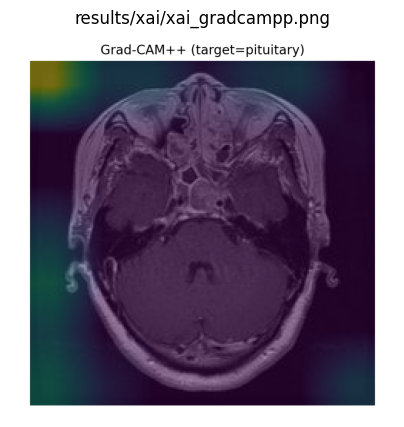

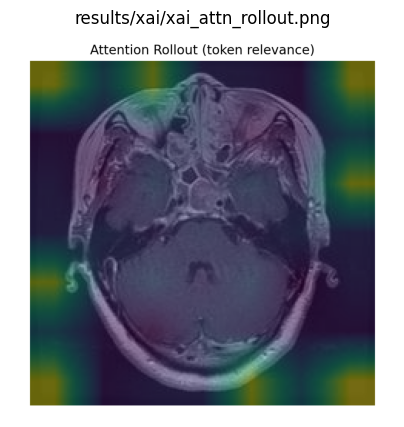

In [40]:
from PIL import Image
import matplotlib.pyplot as plt

for p in ["results/xai/xai_gradcampp.png", "results/xai/xai_attn_rollout.png"]:
    img = Image.open(p)
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.title(p)
    plt.axis("off")
    plt.show()
